# Ant_DF1981-2010

In [1]:
import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
#
import cartopy.crs as ccrs

In [2]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [3]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat=-77.3
        df_lon=39.66
        return df_lon,df_lat,sx,sy

In [4]:
df_lon,df_lat,df_x,df_y = Site().DomeF()    

In [5]:
def Mon():
    import pandas as pd
    mons = pd.DataFrame({
            "name"     : ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan"], 
            "days"     : [31,28,31,30,31,30,31,31,30,31,30,31,31], 
            "dayacc"   : [0,31,59,90,120,151,181,212,243,273,304,334,365], 
            "days_lp"  : [31,29,31,30,31,30,31,31,30,31,30,31,31], 
            "dayacc_lp": [0,31,60,91,121,152,182,213,244,274,305,335,366]             
            })
    return mons
mons=Mon()

In [6]:
monlist=[]
yrlist=[]
yy=[]
for yr in range(12):
    yy      = np.append(yy,1980)
    
for yr in range(30):
    monlist = np.append(monlist,np.arange(1,13,1))
    yy      = yy+1
    yrlist  = np.append(yrlist,yy)

In [7]:
loadfile = "cat/1dy/prcp.npz"
dataset  = np.load(loadfile)
prcp     = dataset["prcp"]
y        = dataset["y"]
m        = dataset["m"]
d        = dataset["d"]

In [8]:
loadfile  = "cat/1dy/prcp_d18O.npz"
dataset   = np.load(loadfile)
prcp_d18O = dataset["prcp_d18O"]

In [9]:
loadfile = "z500mon_eof/sammon.npz"
dataset  = np.load(loadfile)
sammon   = dataset["sam"]

In [10]:
loadfile     = "sammon_jra25.npz"
dataset      = np.load(loadfile)
sammon_jra25 = dataset["sam"][:,0,0]

In [11]:
tmp_d18O = (prcp[df_x-1, df_y-1,:]*prcp_d18O[df_x-1, df_y-1,:])

d18Opw = np.zeros(len(sammon))
t  = 0
mm = 1
yy = 1981

for t in range(len(sammon)):
    d18Opw[t] = np.nanmean(tmp_d18O[(m==mm)&(y==yy)])/np.nanmean(prcp[df_x-1, df_y-1,(m==mm)&(y==yy)])
    mm        = mm + 1
    if mm >12:
        mm = 1    
        yy = yy + 1

In [12]:
# 移動平均
num = 12
b   = np.ones(num)/num

sam_ann                                 = np.convolve(sammon      , b, mode="same")
sam_jra25_ann                           = np.convolve(sammon_jra25, b, mode="same")
d18Opw_ann                              = np.convolve(d18Opw      , b, mode="same")
sam_ann      [             :int(num/2)] = np.nan
sam_jra25_ann[             :int(num/2)] = np.nan
d18Opw_ann   [             :int(num/2)] = np.nan
sam_ann      [-int(num/2)+1:          ] = np.nan
sam_jra25_ann[-int(num/2)+1:          ] = np.nan
d18Opw_ann   [-int(num/2)+1:          ] = np.nan

In [13]:
def hor_lines(ax, yint):
    if len(yint) < 2 :
        ax.axhline(y=yint,ls='-',linewidth=1, color='k')
    else:
        for i in range(len(yint)):
            ax.axhline(y=yint[i],ls='--',linewidth=1, color='k')  
            
    return ax

In [14]:
numofmon  =             len(sammon)
time      = np.arange(0,len(sammon),1)
col_obs   = "black"
col_model = "red"

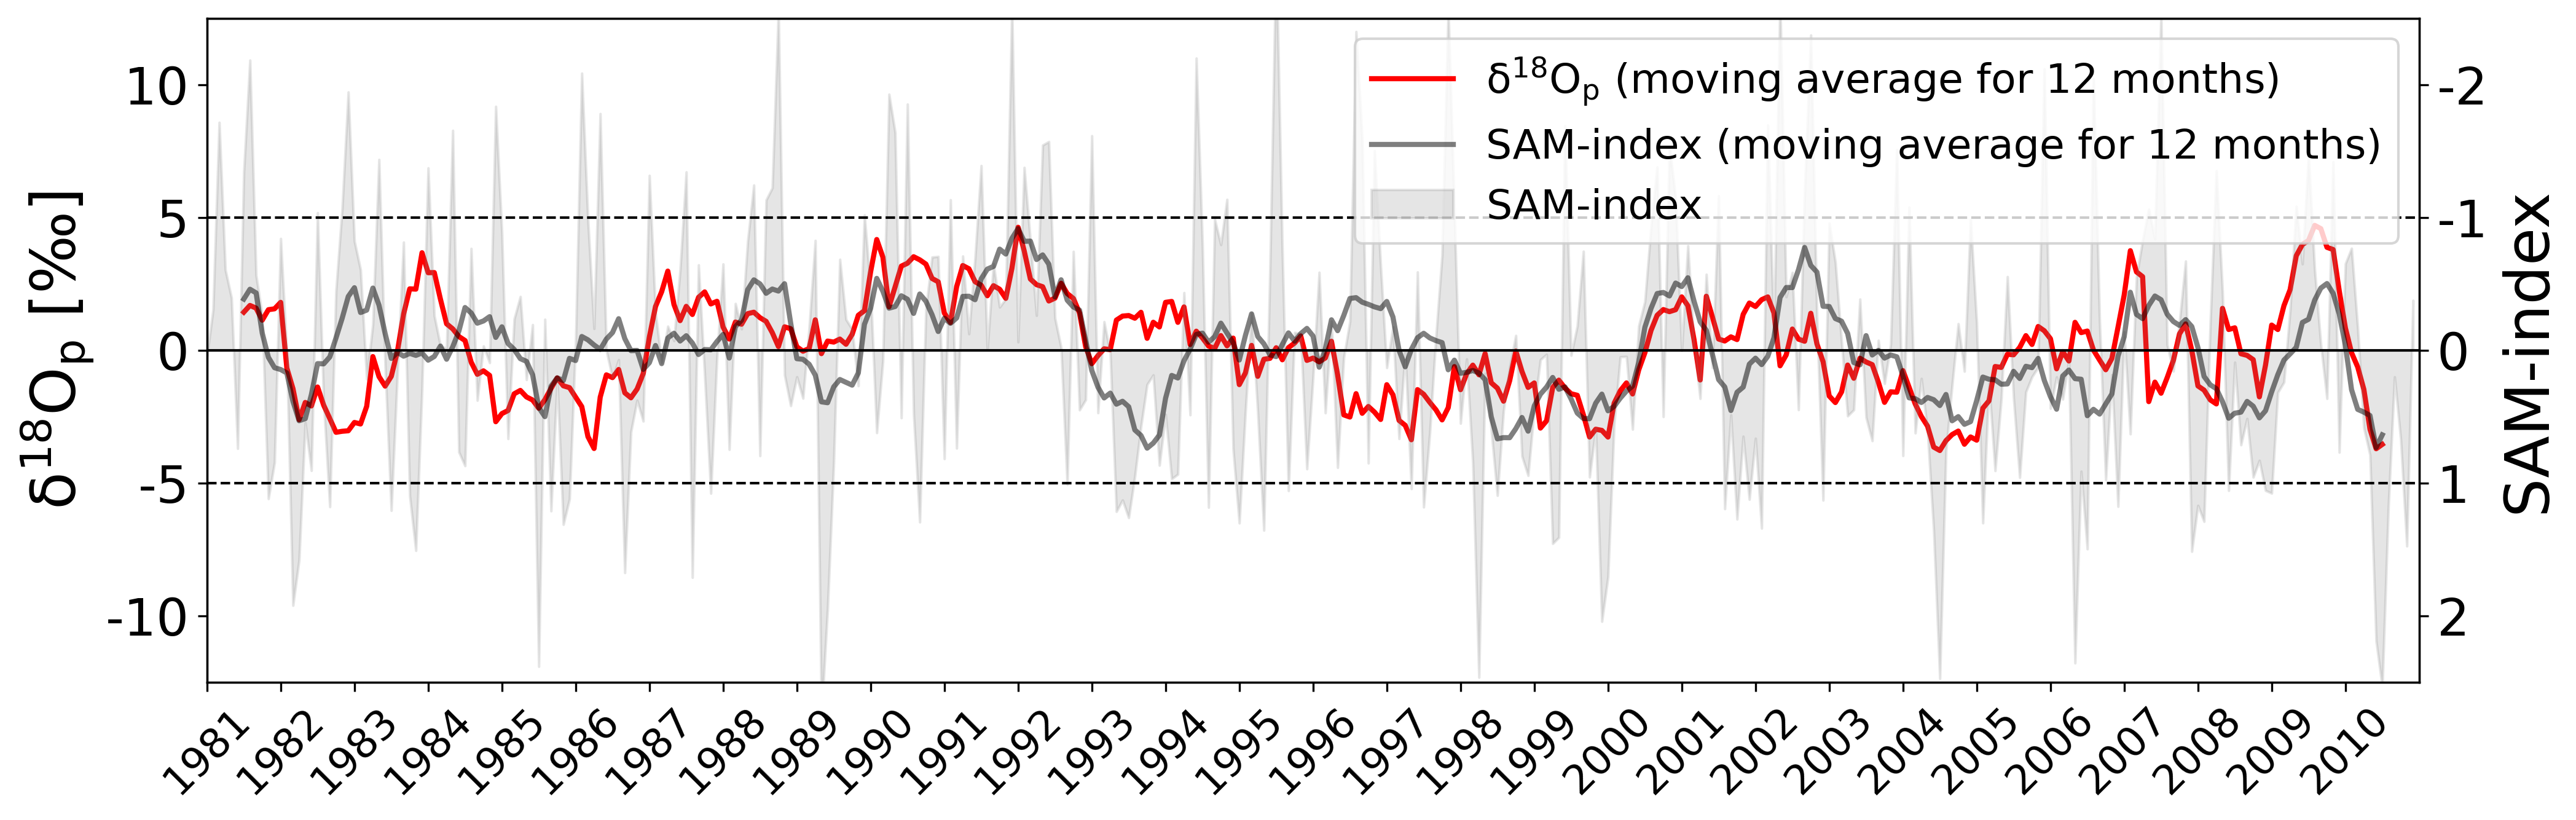

In [15]:
fig = plt.figure(figsize=(15,5)) 

ax = fig.add_subplot(1,1,1)

ax.plot(time,(d18Opw_ann-np.nanmean(d18Opw_ann)), ms=10, color=col_model, linewidth=2,
        label="$\mathrm{\delta^{18}O_{p}}$ (moving average for 12 months)")

ax.tick_params    (               labelsize=24)
ax.set_ylabel     ("$\mathrm{\delta^{18}O_{p}}$ [\u2030]", fontsize=24, color="black") 
ax.set_xlim       (0,numofmon)
ax.set_ylim       (-12.5,12.5)
ax.set_yticks     ([-10,-5,0,5,10])
ax.set_yticklabels([-10,-5,0,5,10],fontsize=16)
ax.tick_params    (               labelsize=20)
ax.set_xticks     (np.arange(0,numofmon,12))
ax.set_xticklabels(np.arange(1981,2011,1),rotation=45,fontsize=16)

ax2=ax.twinx()

ax2.fill_between(time, sammon , color="gray" , alpha=0.2, 
                 label="SAM-index")
ax2.plot(        time, sam_ann, color="black", alpha=0.5, linewidth=2, ms=10, 
         label="SAM-index (moving average for 12 months)")

ax2.tick_params    (labelsize=24)
ax2.set_ylabel     ("SAM-index", fontsize=24, color=col_obs) 
ax2.set_xlim       (0,numofmon)
ax2.set_ylim       (2.5,-2.5)
ax2.set_yticks     ([2,1,0,-1,-2])
ax2.set_yticklabels([2,1,0,-1,-2],fontsize=20)
hor_lines(ax2, [0])
hor_lines(ax2, [-1,1])

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc='best',fontsize=16)

plt.subplots_adjust(top=0.92, bottom=0.2, left=0.1, right=0.9, hspace=0.2, wspace=0.05)
plt.show()
fig.savefig("Ant_DF1981-2010.png")

In [16]:
def corr(a1,a2):
    sa1  = a1[~(np.isnan(a1)+np.isnan(a2))]
    sa2  = a2[~(np.isnan(a1)+np.isnan(a2))]
    
    san1 = (sa1-np.nanmean(sa1))/np.nanstd(sa1)
    san2 = (sa2-np.nanmean(sa2))/np.nanstd(sa2)
    
    r, p = stats.spearmanr(san1,san2)
    
    if r<0:
        rmse = np.sqrt(mean_squared_error(san1*-1,san2))
    else:
        rmse = np.sqrt(mean_squared_error(san1   ,san2))
                         
    return r, p, rmse

In [17]:
r, p, rmse=corr(d18Opw_ann,sam_ann)

print("Spearman's correlation coefficient={:4.2f},".format(r), "p={:}".format(p))
print("RMSE={:4.2f}".format(rmse))

Spearman's correlation coefficient=-0.41, p=1.2848919251468704e-15
RMSE=1.06


In [18]:
r, p, rmse=corr(d18Opw_ann,sam_jra25_ann)

print("Spearman's correlation coefficient={:4.2f},".format(r), "p={:}".format(p))
print("RMSE={:4.2f}".format(rmse))

Spearman's correlation coefficient=-0.41, p=1.5297243818873213e-15
RMSE=1.04


Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)